# Quality control of switches using a checklist

In [3]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from cv2.ximgproc import colorMatchTemplate
from cv2 import matchTemplate

## Set paths to data

In [4]:
TEST_DATA_PATH = os.path.join('..','test_data','switch')
TEST_DATA_PATH_OK = os.path.join(TEST_DATA_PATH,'ok')
TEST_DATA_PATH_FAIL = os.path.join(TEST_DATA_PATH,'fail')

## Define function for image alignment with template

In [5]:
def align_image(im1, im2, warp_mode=cv2.MOTION_EUCLIDEAN, max_iter=5000,\
                corr_inc_eps=1e-10, gauss_filt_size=5):
    """
    :param template_img: path to template image - image of an ideal case
    :param target_img: path to target image which is to be aligned with the template image
    :return: (correlation_coefficient (from -1 to 1), transformed image)
    """
    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iter, corr_inc_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.   
    try:
        (cc, warp_matrix) = cv2.findTransformECC(im1_gray,im2_gray,warp_matrix,\
                                                 warp_mode, criteria, None, gauss_filt_size)
    except:
        print('Processing of %s failed!' % target)
        return 0., im2

    #print("correlation: %3.2f%%" % (cc*100.))

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective(im2, warp_matrix, (im1.shape[1],im1.shape[0]),\
                                          flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP, borderValue=(255,255,255))
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (im1.shape[1],im1.shape[0]),\
                                     flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP, borderValue=(255,255,255))
        
    return cc, im2_aligned

## Define similarity measure (per channel)

In [6]:
def match_images(im1, im2):
    """
    :param template_img:
    :param target_img:
    :return:
    """
    #result = colorMatchTemplate(im1, im2)
    
    #TM_SQDIFF, TM_SQDIFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_CCOEFF, TM_CCOEFF_NORMED
    result = matchTemplate(im1,im2,cv2.TM_SQDIFF_NORMED) 
    
    return result

## Define checklist and show it on the template

In [7]:
import matplotlib.patches as patches

In [15]:
def mask_checklist_items(ax, checklist, classification={}):
    for k,v in checklist.items():
        x1,x2,y1,y2 = v
        color = classification.get(k, 'r')
        rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=2,edgecolor=color,facecolor='none')    
        ax.add_patch(rect)

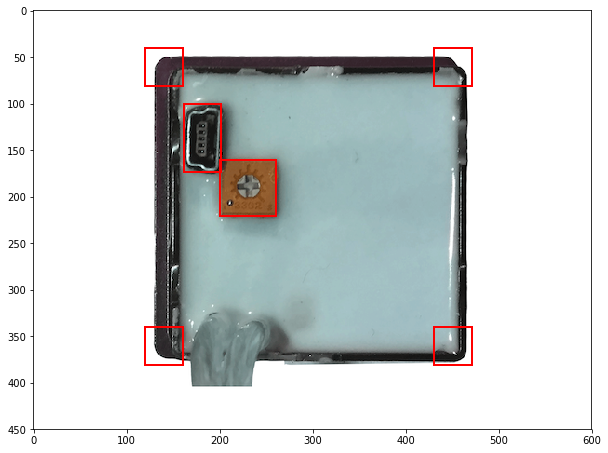

In [16]:
template_img = cv2.imread(os.path.join(TEST_DATA_PATH_OK,'switch-0-ok.png'))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(template_img)

# following check list had been clicked by user... in some GUI...
checklist = {'upper left corner':  (120,160,40,80),
             'upper right corner': (430,470,40,80),
             'lower left corner':  (120,160,340,380),
             'lower right corner': (430,470,340,380),
             'connector':          (200,260,160,220),
             'trimmer':            (162,200,100,172)}
            
mask_checklist_items(ax, checklist)

## Put everything together

((450, 600, 3), (450, 600, 3), '[] agreement 0.000-0.000,0.000-0.000,0.000-0.000": "switch-0-ok.png"')
((450, 600, 3), (450, 600, 3), '[] agreement 0.073-0.073,0.052-0.052,0.000-0.000": "switch-1-ok.png"')
((450, 600, 3), (450, 600, 3), '[] agreement 0.156-0.156,0.298-0.298,0.002-0.002": "switch-0-fail.png"')
((450, 600, 3), (450, 600, 3), '[] agreement 0.086-0.086,0.055-0.055,0.000-0.000": "switch-1-fail.png"')


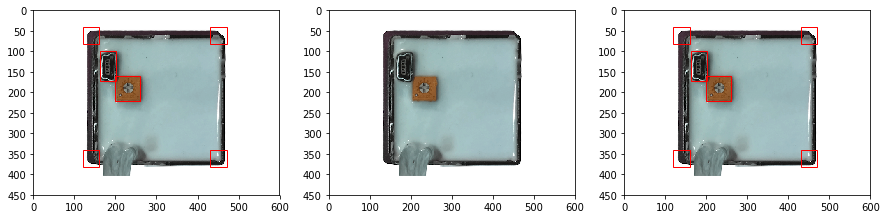

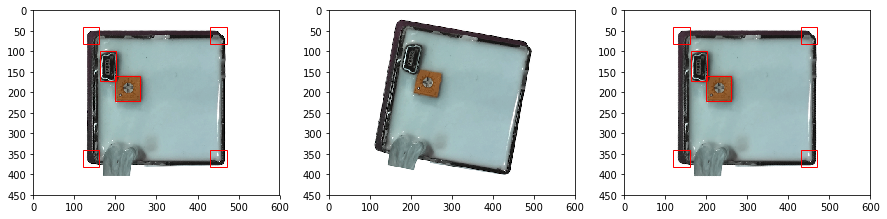

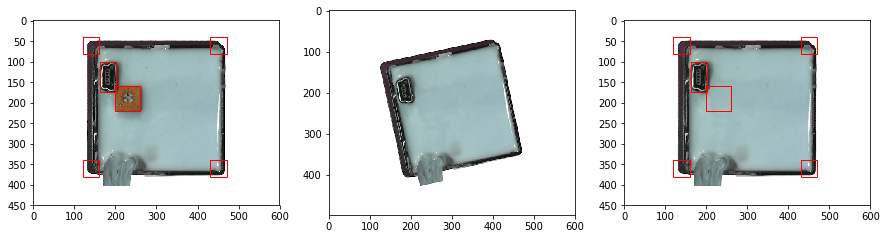

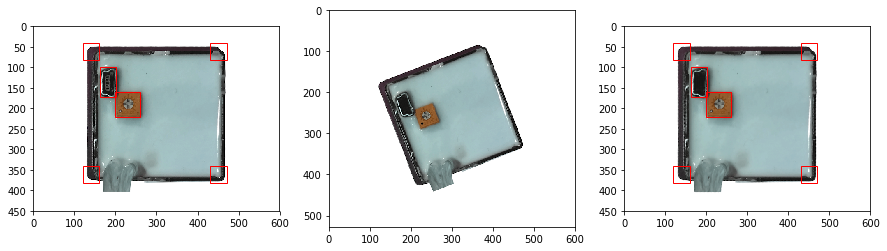

In [10]:
failures = sorted([os.path.join(TEST_DATA_PATH_FAIL,x) for x in filter(lambda x: x.endswith('png'), os.listdir(TEST_DATA_PATH_FAIL))])
oks = sorted([os.path.join(TEST_DATA_PATH_OK,x) for x in filter(lambda x: x.endswith('png'), os.listdir(TEST_DATA_PATH_OK))])
#images = oks+failures
images = oks[:2]+failures[:2]

THRESHOLD = 0.98

# source image - template to which we compare
template_img = cv2.imread(os.path.join(TEST_DATA_PATH_OK,'switch-0-ok.png'))

template_img_HSV = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)
template_img_H, template_img_S, template_img_V = cv2.split(template_img_HSV)

H_points = []
S_points = []
V_points = []

for target in images:
    target_img = cv2.imread(target)

    cc, target_img_rot = align_image(template_img, target_img, warp_mode=cv2.MOTION_HOMOGRAPHY)    
    target_img_rot_HSV = cv2.cvtColor(target_img_rot, cv2.COLOR_BGR2HSV)    

    target_img_rot_H, target_img_rot_S, target_img_rot_V = cv2.split(target_img_rot_HSV)

    score_mat_H = match_images(template_img_H, target_img_rot_H)
    score_mat_S = match_images(template_img_S, target_img_rot_S)
    score_mat_V = match_images(template_img_V, target_img_rot_V)    
    
    H_points.append(score_mat_H.max())
    S_points.append(score_mat_S.max())
    V_points.append(score_mat_V.max())    
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(131)
    ax.imshow(template_img)
    mask_checklist_items(ax, checklist)
    ax = fig.add_subplot(132)
    ax.imshow(target_img)    
    ax = fig.add_subplot(133)
    ax.imshow(target_img_rot)
    mask_checklist_items(ax, checklist)

    #label = 'PASS' if cc > THRESHOLD else 'DEFECT'
    #print('[%s] agreement %3.2f%%": "%s"' % (label, cc*100., target))

    print(template_img.shape, target_img_rot.shape, '[%s] agreement %4.3f-%4.3f,%4.3f-%4.3f,%4.3f-%4.3f": "%s"' % ('',score_mat_H.min(),score_mat_H.max(),score_mat_S.min(),score_mat_S.max(),score_mat_V.min(),score_mat_V.max(),target.split(os.sep)[-1]))
    

### Separability of classes 

In [8]:
H_vec = np.array(H_points)
S_vec = np.array(S_points)
V_vec = np.array(V_points)

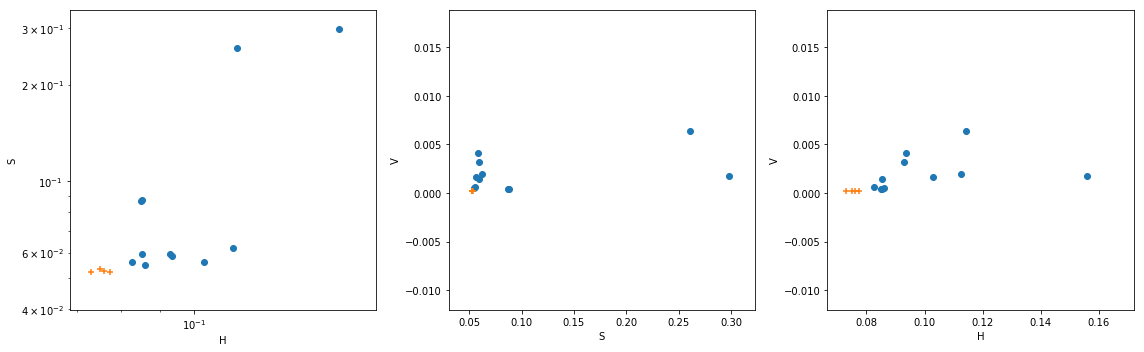

In [25]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(131)
ax.scatter(H_vec[5:], S_vec[5:])
ax.scatter(H_vec[1:5], S_vec[1:5], marker='+')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('H')
ax.set_ylabel('S')

ax = fig.add_subplot(132)
ax.scatter(S_vec[5:], V_vec[5:])
ax.scatter(S_vec[1:5], V_vec[1:5], marker='+')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('S')
ax.set_ylabel('V')

ax = fig.add_subplot(133)
ax.scatter(H_vec[5:], V_vec[5:])
ax.scatter(H_vec[1:5], V_vec[1:5], marker='+')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('H')
ax.set_ylabel('V')


plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(131)
ax.imshow(im1)
ax.set_title('What we want')
ax = fig.add_subplot(132)
ax.set_title('Camera image (possibly defected piece)')
ax.imshow(im2)
ax = fig.add_subplot(133)
ax.set_title('After tranformation')
ax.imshow(im2_aligned)